In [15]:
import fixed_income_derivatives_E2024 as fid
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, root_scalar, minimize_scalar
from scipy.stats import norm, ncx2, gamma
import copy
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns

Parameters from the fit without sigma: [0.03200626 1.98969837 0.04701493]. SE of the fit: 2.6261479063949182e-09
[0.0334048  0.03518849 0.0375024  0.03921056 0.04049145 0.04222307
 0.04329243 0.04448048 0.0451005  0.04547535 0.04590434 0.04622613]


/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_91478/3122570161.py:10: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_cir_no_sigma_obj,param_0,method = 'nelder-mead',args = (sigma,R,T),options={'xatol': 1e-20,'disp': True})


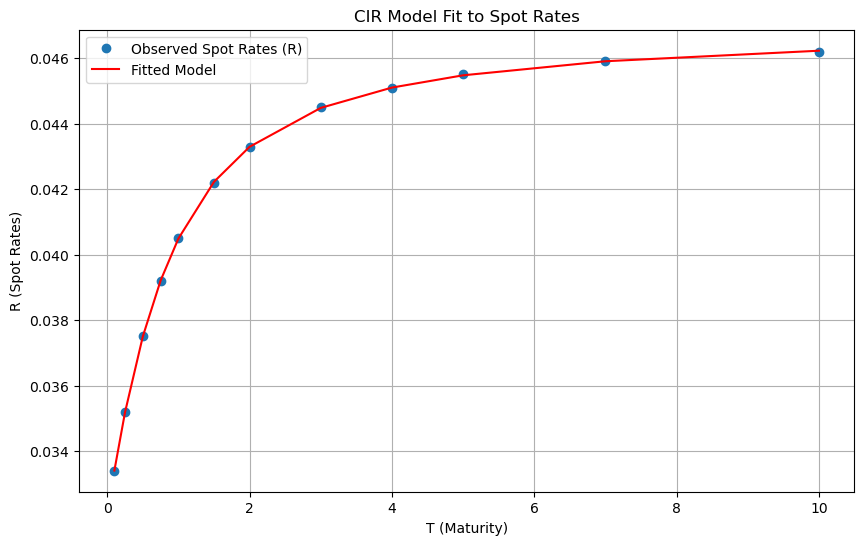

In [16]:
# 1a) We are given spot rates
T = [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 7, 10]
R = [0.0334, 0.0352, 0.0375, 0.0392, 0.0405, 0.0422, 0.0433, 0.0445, 0.0451, 0.0455, 0.0459, 0.0462]

sigma = 0.08
r0 = 0.025
a, b = 1.5, 0.07
# i)
param_0 = a, b, r0
result = minimize(fid.fit_cir_no_sigma_obj,param_0,method = 'nelder-mead',args = (sigma,R,T),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit without sigma: {result.x}. SE of the fit: {result.fun}")
r0_hat, a_hat, b_hat = result.x

# ii)
r = fid.spot_rate_cir(r0_hat,a_hat,b_hat,sigma,T)
print(r)

plt.figure(figsize=(10, 6))
plt.plot(T, R, 'o', label='Observed Spot Rates (R)')
plt.plot(T, r, '-', label='Fitted Model', color='red')
plt.xlabel('T (Maturity)')
plt.ylabel('R (Spot Rates)')
plt.title('CIR Model Fit to Spot Rates')
plt.legend()
plt.grid(True)
plt.show()

[0.0334048  0.03518849 0.0375024  0.03921056 0.04049145 0.04222307
 0.04329243 0.04448048 0.0451005  0.04547535 0.04590434 0.04622613]


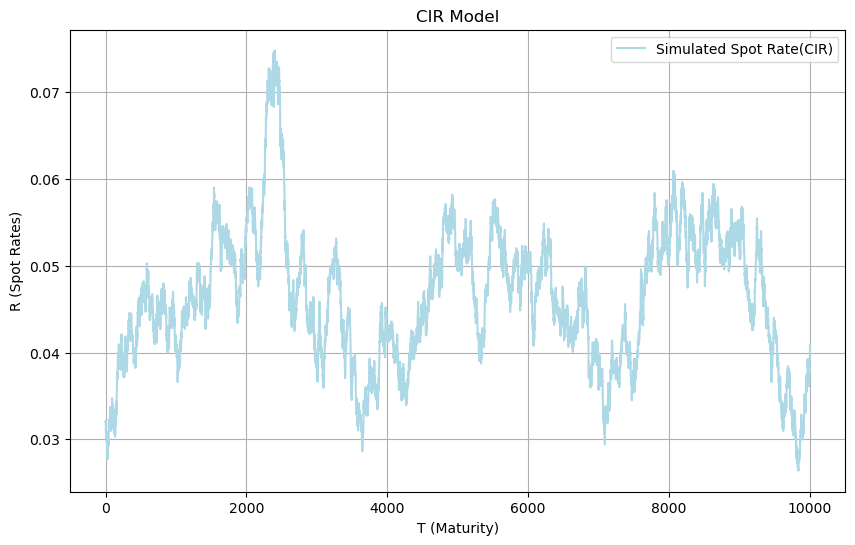

Lower bound: 0.026483729458952773
Upper bound: 0.06910090218798627
Stationary Lower Bound: 0.02763289901261407
Stationary Upper Bound: 0.07241634049828757


In [ ]:
# 1b) 
T_simul = 10 
M_simul = 10000

# i)
r_simul = fid.simul_cir(r0_hat,a_hat,b_hat,sigma,M_simul,T_simul,method = "euler")
print(r)

plt.figure(figsize=(10, 6))
plt.plot( r_simul, '-', label='Simulated Spot Rate(CIR)', color='lightblue')
plt.xlabel('T (Maturity)')
plt.ylabel('R (Spot Rates)')
plt.title('CIR Model')
plt.legend()
plt.grid(True)
plt.show()

# ii) We use the following function to find the confidence bounds
T_simul_i = 1
ci = 0.99
lb, ub = fid.ci_cir(r0_hat,a_hat,b_hat,sigma,T_simul_i,ci)
print(f"Lower bound: {lb}")
print(f"Upper bound: {ub}")


# iii) We find the stationary confidence bounds by the "closed" form solution 
alpha = (2*a_hat*b_hat)/sigma**2
beta = (2*a_hat)/sigma**2
lb_st = gamma.ppf(0.005, alpha, scale=1/beta)
ub_st = gamma.ppf(0.995, alpha, scale=1/beta)
print(f"Stationary Lower Bound: {lb_st}")
print(f"Stationary Upper Bound: {ub_st}")


In [ ]:
# 1c) 

T_c = 2
M_c = 1000 
t0 = 0 
t = np.linspace(t0, T_c, M_c+1)
N = 1000
df = np.zeros(N)

# i)
for i in range(N):
    rates = fid.simul_cir(r0_hat,a_hat,b_hat,sigma,M_c,T_c,method = "euler")
    df[i] = np.exp(-T_c * np.mean(rates)) * np.max(rates)
fair_val = np.mean(df)    
print(f"Fair value of complex derivatives {fair_val}")

# ii) 



Fair value of complex derivatives 0.05457803087954446


# Problem 2

In [ ]:
# 2a) 

EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.02927}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12,
"rate": 0.03161},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.03295},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.03418},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.03531},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.03635},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.03731},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.03819},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.03900},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.03975}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.03824,
"float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.04083, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.04242, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.04346, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.04468, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.04561, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.04633, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.04667, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.04700, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

In [139]:
# i)
 
T = [0.5, 1, 3, 5 ,10, 20, 30]
interpolation_options = {"method":"hermite","degree":2,"transition": "smooth"}
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
T_6m = np.array([i*0.5 for i in range(0,61)])
p_inter_mat, R_inter_mat, f_inter_mat, T_inter_mat = fid.zcb_curve_interpolate(T,T_fit,R_fit,interpolation_options = interpolation_options)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_6m,T_fit,R_fit,interpolation_options = interpolation_options)
print(R_inter_mat)





[0.02905788 0.03301207 0.04061185 0.04329832 0.04552815 0.04666068
 0.04703893]


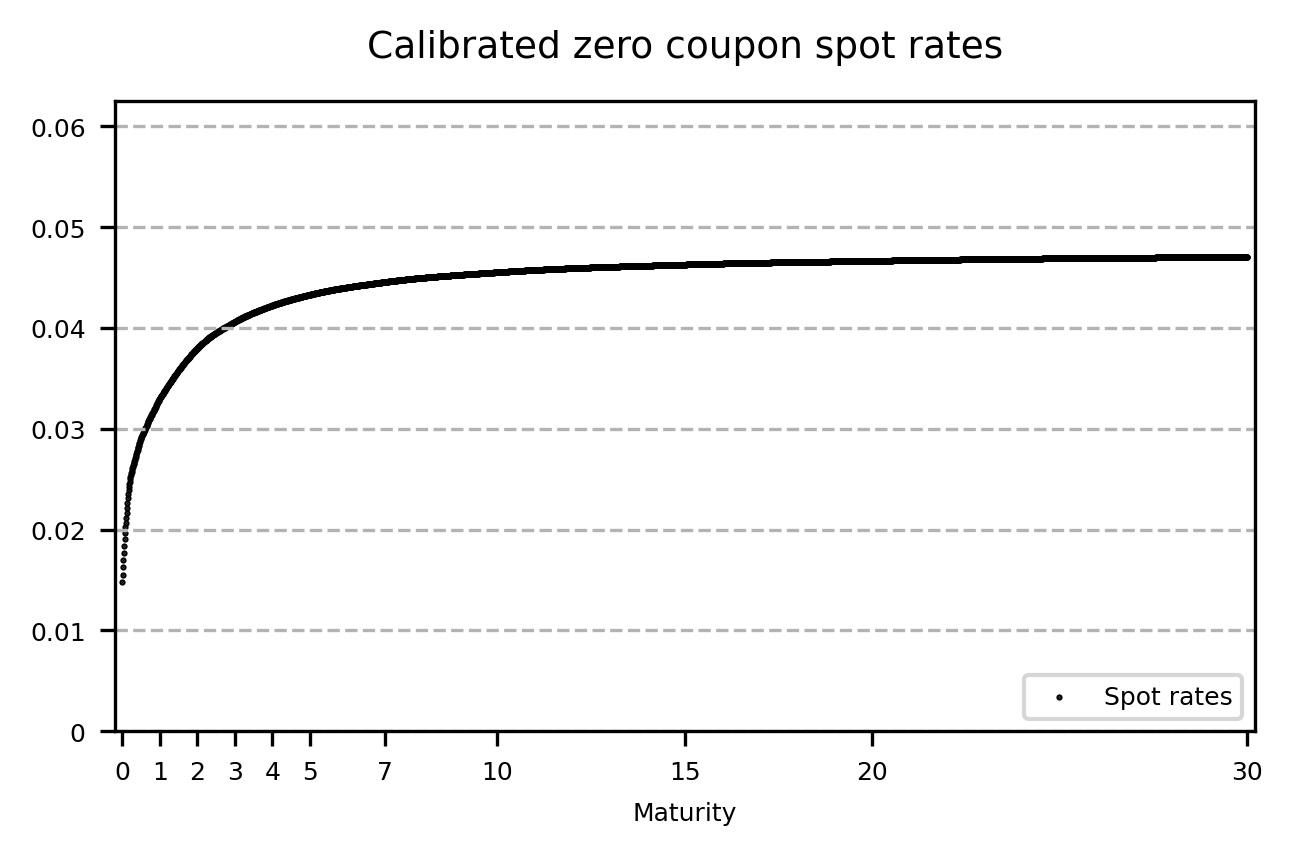

In [138]:
# ii) 

fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,
hspace=0)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,
hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter, R_inter, s = 1, color = 'black', marker = ".",label="Spot rates")
# p2 = ax.scatter(T_inter, p_inter, s = 1, color = 'red', marker = ".",label="ZCB rates")
# p3 = ax.scatter(T_swap, R_swap, s = 1, color = 'green', marker = ".",label="par swap rates")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()


In [136]:
# 2b) 
T = [0.5, 1, 3, 5 ,10, 20, 30]
interpolation_options = {"method":"hermite","degree":2,"transition": "smooth"}
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
T_6m = np.linspace(0, 30, 96*30)
p_inter_b, R_inter_b, f_inter_b, T_inter_b = fid.zcb_curve_interpolate(T_6m,T_fit,R_fit,interpolation_options = interpolation_options)

# Convert to ZCB and then to Forward Rates 
zcb_prices = fid.zcb_prices_from_spot_rates(T_inter_b,R_inter_b) 
forward_rates = fid.forward_rates_from_zcb_prices(T_inter_b,zcb_prices,0) # 0 because we want the instantanoeus spot rate. See FID-file

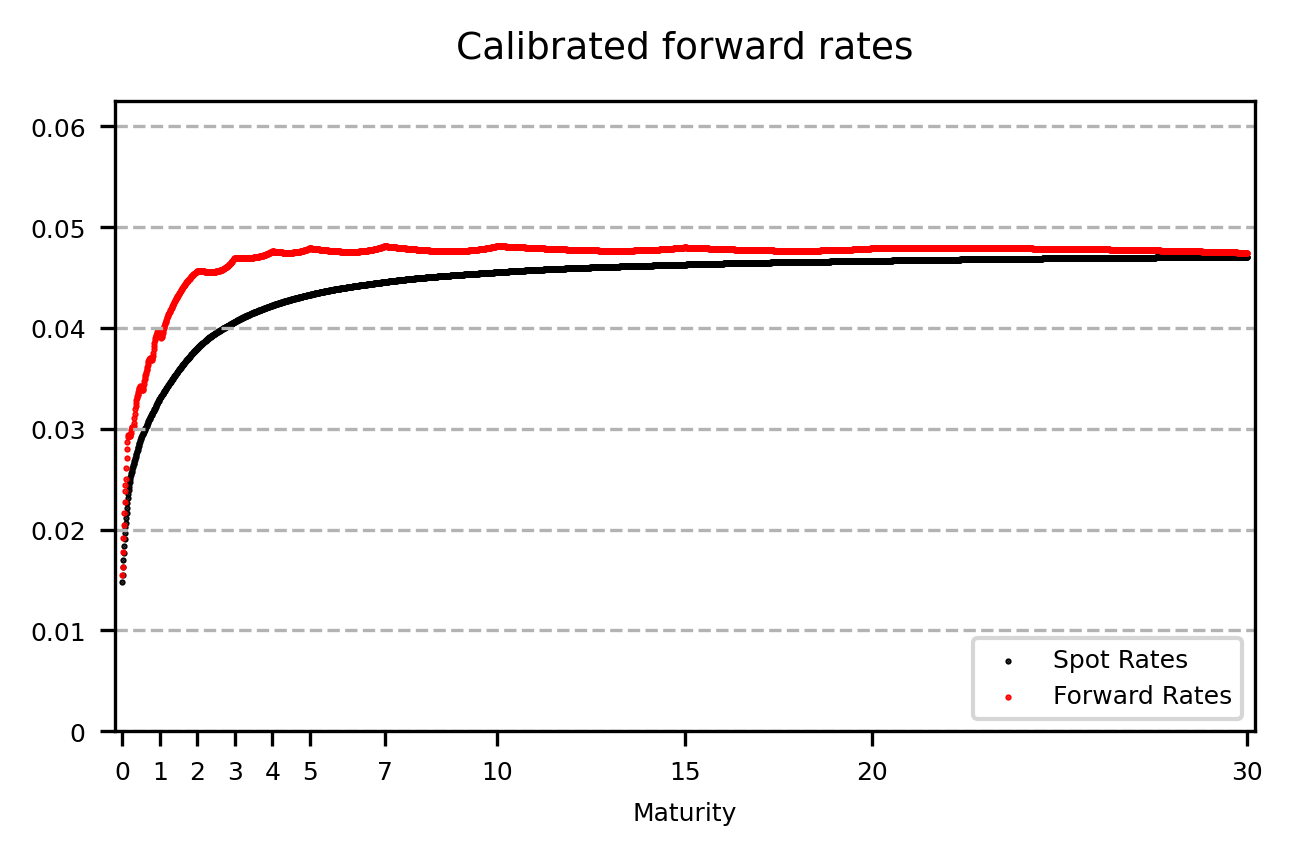

In [137]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated forward rates", fontsize = 9)
fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,
hspace=0)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,
hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter_b, R_inter_b, s = 1, color = 'black', marker = ".",label="Spot Rates")
p2 = ax.scatter(T_inter_b, forward_rates, s = 1, color = 'red', marker = ".",label="Forward Rates")
# p3 = ax.scatter(T_swap, R_swap, s = 1, color = 'green', marker = ".",label="par swap rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()


#ii) 

The instantaneous forward rates should be continuous to prevent that interest rate derivatives with nearly the same maturity can have vastly different prices. Instantaneous forward rates will be continuous if and only if zero coupon bond prices are differentiable

#iii) 

Whether zero coupon bond prices are differentiable depends on the method of interpolation and if for example a piecewise linear interpolation, or for that matter any other ’piecewise’ method, is used, instantaneous forward rates will be discontinuous as in the above

In [ ]:
# 2c) 
# First we find the par swap rate, afterwards we bump it to see the price change? 

# swap_id, size_bump = 7, 0.0001
# print(f"Bumping spot rates")
# def dv01_swap_spot_rate_bump_fct(t,T_n,T_N,fixed_freq,R_swap_init,T_bump,size_bump,T_inter,R_inter,p_inter):
#     R_bump, p_bump = fid.spot_rate_bump(T_bump,size_bump,T_inter,R_inter,p_inter)
#     R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(t,T_n,T_N,fixed_freq,T_inter,p_bump)
#     DV01 = (R_swap_bump-R_swap_init)*S_swap_bump
#     return DV01

# # i)
# DV01 = dv01_swap_spot_rate_bump_fct(0,0,7,"semiannual", 0.04468, T_inter, size_bump, T_inter, R_inter, p_inter)
# print(DV01*10000)

# # ii)
# T_2_c = [1,2,3,5,7]
# DV01_bump = np.zeros(T_2_c)
# # T_bump = np.array([i for i i])
# for i, val in range(T_2_c):
#     DV01_bump[i] = dv01_swap_spot_rate_bump_fct(0,0,data[swap_id]["maturity"],"semiannual",data[swap_id]["rate"],val,size_bump,T_inter,R_inter,p_inter)
# print(f"DV01 when bumping each spot rate separately: {10000*DV01_bump}")

Bumping spot rates
6.049300165911291


TypeError: 'list' object cannot be interpreted as an integer

In [151]:
# Second approach: 
# ii)
fixed_leg = 1/2*np.sum(p_inter[1:15])*0.04468
floating_leg =(p_inter[0]-p_inter[14])
price = floating_leg - fixed_leg
print('Price now:', price)
spot_rates_bumped = R_inter.copy() + 0.0001
zcb_prices_bumped = fid.zcb_prices_from_spot_rates(T_inter, spot_rates_bumped)

fixed_leg_bumped = 1/2*np.sum(zcb_prices_bumped[1:15])*0.04468
floating_leg_bumped = (zcb_prices_bumped[0] -  zcb_prices_bumped[14])

price_bumped = floating_leg_bumped - fixed_leg_bumped
print('Price bumped:', price_bumped)
delta = (price_bumped - price)
print('delta:', delta)

Price now: -2.760191512907184e-06
Price bumped: 0.0006049300165911209
delta: 0.0006076902081040281


In [153]:
T_2_c = np.array([1, 2, 3, 5, 7])
dv01 = np.zeros(len(T_2_c))
for i in range(len(T_2_c)):
    fixed_leg = 1/2*np.sum(p_inter[1:15])*0.04468
    floating_leg = (p_inter[0] -  p_inter[14])
    price = floating_leg - fixed_leg
    spot_rates_bumped = R_inter.copy()
    spot_rates_bumped[T_2_c[i]*2] += 0.0001
    zcb_prices_bumped = fid.zcb_prices_from_spot_rates(T_inter, spot_rates_bumped)
    fixed_leg_swap_bumped = 1/2*np.sum(zcb_prices_bumped[1:15])*0.04468
    floating_leg_swap_bumped = (zcb_prices_bumped[0] -  zcb_prices_bumped[14])
    price_bumped = floating_leg_swap_bumped - fixed_leg_swap_bumped
    delta = (price_bumped - price)
    dv01[i] = delta
print('dv01:', dv01)

dv01: [2.16134698e-06 4.14060717e-06 5.93235017e-06 8.99339139e-06
 5.23700120e-04]


#iii) 

It is more sensitive to the back end, as the bumps are higher. 

"The 7Y swap is more exposed to bumps in the spot rate for higher maturities but is almost entirely exposed to the spot rate with same maturity as the swap itself. This reveals that though seemingly very different, an interest rate swap behaves much like a zero coupon bond in terms of delta risk exposure."

# Problem 3

In [ ]:
# 3a) 

T_3 = np.array([0.5,1,1.5,2,2.5,3,3.5,4])
R_3 = np.array([0.0385, 0.0431, 0.0463, 0.0486, 0.0502, 0.0513, 0.0521, 0.0527])
sigma_3 = np.array([0, 0.223, 0.241, 0.260, 0.283, 0.312, 0.355, 0.402])


p_3  = fid.zcb_prices_from_spot_rates(T_3, R_3)
f_3 = fid.forward_libor_rates_from_zcb_prices(T_3, p_3, 1)

tabel = pd.DataFrame({
    'T_3': T_3,
    'f_3': f_3
})


print(tabel)

   T_3       f_3
0  0.5  0.000000
1  1.0  0.048273
2  1.5  0.053400
3  2.0  0.056277
4  2.5  0.057408
5  3.0  0.057614
6  3.5  0.057717
7  4.0  0.057717


In [ ]:
# 3b
# i)
 
# Recall that T_n is start start of the swap, not the first payment. Unless we have forward swap T_n should be 0
swap_R, swap_S = fid.swap_rate_from_zcb_prices(0, 0, 4,"semiannual",T_3, p_3, "semiannual", 0)
print(f"Swap rate {swap_R}")
print(f"Accrual factor {swap_S}")


Swap rate 0.05307796270952918
Accrual factor 3.580845089117633


In [261]:
# ii) 

price_caplet = fid.black_caplet_price(sigma=sigma_3[1:], T=T_3[:-1], R=0.05, alpha=0.5, p=p_3[1:],L=f_3[1:], type ="call" )
# T are the fixing dates. Not the payments
# L are the Libor Rates 
# R is the strike 
PV_cap = np.sum(price_caplet)
print(PV_cap)
print("Semiannual premium:", np.sum(price_caplet)*1/(2*swap_S)*10000)



0.03612243247858449
Semiannual premium: 50.43841827780035


In [293]:
# iii) 
S = 0
for i in range(4, 8):  
    S += p_3[i] * 0.5  

print(f"Annuity Factor (S): {S}")

sigma = 0.39  
T = 2         
K = 0.05      
# First we find the new price of the swap(Here 2,4), then we use these inputs(Par swap rate and accrual factor)
# 
swap_R_i, swap_S_i = fid.swap_rate_from_zcb_prices(0, 2, 4,"semiannual",T_3, p_3, "semiannual", 0)
print(f"Swap rate 4Y{swap_R_i}")
print(f"Accrual factor 4Y {swap_S_i}")

# Inputs are the par swap rate and 
swaption_price = fid.black_swaption_price(sigma=sigma, T=T, K=K, S=swap_S_i, R=swap_R_i, type="call")
print(f"2Y2Y Payer Swaption Price: {swaption_price}")

semi_annual_prem = swaption_price/(2*swap_S)
print("Semi-annual Premium:", semi_annual_prem*10000)


Annuity Factor (S): 1.691329592908512
Swap rate 4Y0.05761057785501258
Accrual factor 4Y 1.691329592908512
2Y2Y Payer Swaption Price: 0.02683993510220535
Semi-annual Premium: 37.47709609635621


 i) The fixed rate coupon bond is given as 0.0531

 ii) The spread is given as 50.44 Basis Points

 iii) The spread is given as 37.48 Basis Points
 


3c)
#### i) Swapping Floating Rate Payments into Fixed Coupon Payments
By converting floating rate payments into a fixed stream of coupon payments, the client eliminates all uncertainty regarding future interest rate fluctuations. This approach provides stability and predictability in cash flows. However, it comes at the cost of losing potential benefits if interest rates decline in the future. In such a case, the client will not enjoy lower interest payments, as they are locked into the fixed rate.

#### ii) Entering into an Interest Rate Cap
Purchasing an interest rate cap ensures that the client’s interest payments will not exceed a specified level (0.05 in this case) at any point in the future. This approach protects against rising interest rates and provides some upside if rates fall, as the client can still benefit from lower rates. However, the cap comes at a cost, represented by the premium, which the client must pay irrespective of whether the cap is eventually exercised. For this scenario, the premium is approximately 50 basis points per year, paid semi-annually.

#### iii) Entering into a 2Y2Y Payer Swaption
Opting for a 2Y2Y payer swaption gives the client the right, but not the obligation, to enter into a fixed-for-floating swap in two years. This guarantees that the interest rate will not exceed 0.05 after two years. However, this strategy does not protect against potential interest rate increases during the first two years. As a result, this option carries higher risk compared to an interest rate cap. Nevertheless, it is also less costly than the cap due to its limited coverage period. Like the cap, this strategy allows the client to benefit from low future interest rates while insuring against significant rate increases after the exercise period.


# Problem 4

In [ ]:
# 4a) 


T_4a = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0])
p_4a = np.array([0.98322948, 0.96455878, 0.94449414, 0.92344747, 0.90175113, 0.85741902, 0.83516131, 0.81302835, 0.79112104, 0.76951663, 0.87967118, 0.7482734])
K_offsets = np.array([-300, -250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300]) 
pi_swap = np.array([0.0995524, 0.08350629, 0.06774531, 0.05248227, 0.03808218, 0.02519355, 0.01482874, 0.00785645, 0.00404525, 0.00219232, 0.00128815, 0.00081635, 0.00054773])
# f_4a = fid.forward_rates_from_zcb_prices(T_4a,p_4a,horizon = 1)

#i) 
R_ATM = 0.0531157  # ATM forward swap rate

# Calc strike prices 
K = R_ATM + K_offsets / 10000
print("Strikes (K):", K)
swap_rate, accrual_rate =fid.swap_rate_from_zcb_prices(0, 2, 6, "semiannual", T_4a, p_4a, "semiannual")
print(f"Swap-rate: {swap_rate}")
print(f"Accrual: {accrual_rate}")




Strikes (K): [0.0231157 0.0281157 0.0331157 0.0381157 0.0431157 0.0481157 0.0531157
 0.0581157 0.0631157 0.0681157 0.0731157 0.0781157 0.0831157]
Swap-rate: 0.053115709145571254
Accrual: 3.2979710300000002


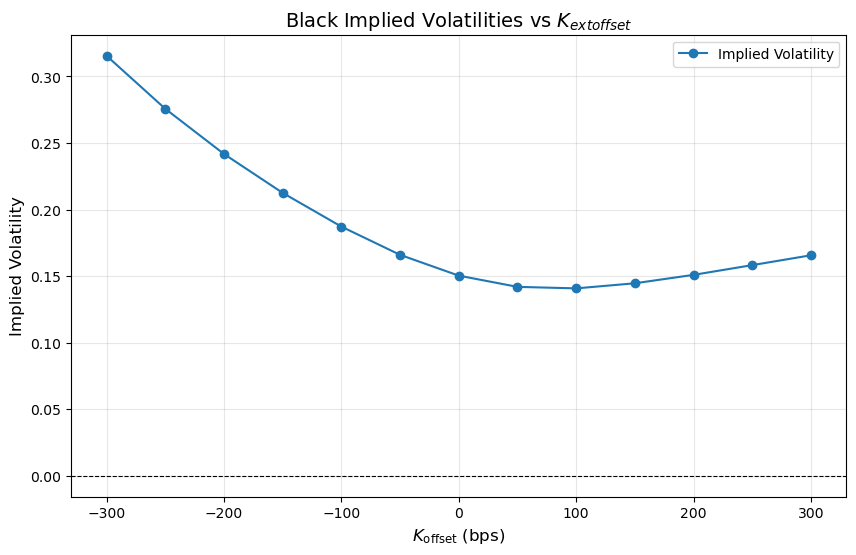

In [322]:
#ii) 

black_iv = []
# T here denotes the expiry of the option not the swap. 
# R is the current swap rate
for i, K_i in enumerate(K):
    C = pi_swap[i]  # Price of the swaption
    implied_vol = fid.black_swaption_iv(C=C, T=2, K=K_i, S=accrual_rate, R=swap_rate, type="call")
    black_iv.append(implied_vol)

# Convert to numpy array for further analysis
black_iv = np.array(black_iv)

plt.figure(figsize=(10, 6))
plt.plot(K_offsets, black_iv, marker='o', linestyle='-', label='Implied Volatility')

# Add labels and title
plt.xlabel(r"$K_{\text{offset}}$ (bps)", fontsize=12)
plt.ylabel("Implied Volatility", fontsize=12)
plt.title("Black Implied Volatilities vs $K_{\text{offset}}$", fontsize=14)
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--') 
plt.grid(alpha=0.3)
plt.legend()

# Show the plot
plt.show()

iii) There is in a ’smirk’ in implied volatilities clearly indicating that market prices are not equivalent to what would arise in a Black’s model. The pricing measure chosen by the market is not compatible with the 2Y 4Y forward par swap rate following a log-normal distribution. The distribution implied by the measure chosen by the market has more fat tails and displays more left skewness than that of a log-normal random variable. This is a finding that is very much consistent with typical market behavior

In [ ]:
# 4b)
#i)
param_0 = 0.04, 0.5, 0.4,-0.3
result = minimize(fid.fit_sabr_obj,param_0,method = 'nelder-mead',args = (black_iv,K,2,swap_rate),options={'xatol': 1e-8,'disp': True})
sigma_0_tilde, beta_tilde, upsilon_tilde, rho_tilde = result.x

print(f"Sigma: {sigma_0_tilde:.2f}")
print(f"Beta: {beta_tilde:.2f}")
print(f"Upsilon: {upsilon_tilde:.2f}")
print(f"Rho: {rho_tilde:.2f}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 447
         Function evaluations: 750
Sigma: 0.06
Beta: 0.70
Upsilon: 0.60
Rho: -0.35


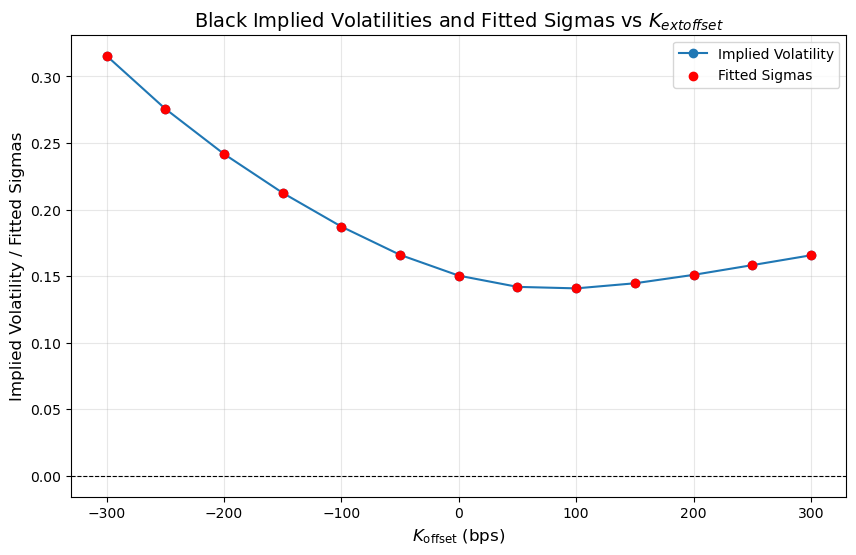

In [337]:
# ii) 
sigmas = []

for i, K_i in enumerate(K):
    fitted_sigmas = fid.sigma_sabr(K_i, 2, swap_rate, sigma_0_tilde, beta_tilde, upsilon_tilde, rho_tilde)
    sigmas.append(fitted_sigmas)

plt.figure(figsize=(10, 6))
plt.plot(K_offsets, black_iv, marker='o', linestyle='-', label='Implied Volatility')

# Add fitted sigmas as a scatter plot
plt.scatter(K_offsets, sigmas, color='red', label='Fitted Sigmas', zorder=5)
plt.xlabel(r"$K_{\text{offset}}$ (bps)", fontsize=12)
plt.ylabel("Implied Volatility / Fitted Sigmas", fontsize=12)
plt.title("Black Implied Volatilities and Fitted Sigmas vs $K_{\text{offset}}$", fontsize=14)
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--') 
plt.grid(alpha=0.3)
plt.legend()

# Display the plot
plt.show()


In [359]:
# 4c)
new_upsilon = upsilon_tilde - 0.02
new_rho = rho_tilde + 0.1
new_ZCB_rates = p_4a + 0.0001

# i) 
sigma_upsi = fid.sigma_sabr(K[4], 2, swap_rate, sigma_0_tilde, beta_tilde, new_upsilon, rho_tilde)
swap_upsi = fid.black_swaption_price(sigma=sigma_upsi,T=2, K=K[4], S=accrual_rate, R=swap_rate)
print(swap_upsi)
DELTA = (swap_upsi-pi_swap[4])
print(DELTA)


0.03796525754763867
-0.00011692245236132742


In [360]:
# ii) 
sigma_rho = fid.sigma_sabr(K[4], 2, swap_rate, sigma_0_tilde, beta_tilde, upsilon_tilde, new_rho)
swap_rho = fid.black_swaption_price(sigma=sigma_rho,T=2, K=K[4], S=accrual_rate, R=swap_rate)
print(swap_upsi)
DELTA = (swap_rho-pi_swap[4])
print(DELTA)


0.03796525754763867
-0.00020038248730849806


In [366]:
#iii) 
new_spot_rates = fid.spot_rates_from_zcb_prices(T_4a,p_4a)
R_new = new_spot_rates - 0.0001
ZCB_new = fid.zcb_prices_from_spot_rates(T_4a,R_new)

swap_rate_new, accrual_rate_new =fid.swap_rate_from_zcb_prices(0, 2, 6, "semiannual", T_4a, ZCB_new, "semiannual")
sigma_ZCB = fid.sigma_sabr(K[4], 2, swap_rate_new, sigma_0_tilde, beta_tilde, upsilon_tilde, rho_tilde)
swap_ZCB = fid.black_swaption_price(sigma=sigma_ZCB,T=2, K=K[4], S=accrual_rate_new, R=swap_rate_new)
DELTA = (swap_ZCB-pi_swap[4])
print(DELTA)

-0.00028426085056637573
